In [78]:
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

import numpy as np
import matplotlib.pyplot as plt

import math

In [79]:
input_size = 784
num_classes = 10
num_epochs = 20
batch_size = 100
learning_rate = 0.1

In [80]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

reduced_train_index=list(range(10000))
reduced_test_index=list(range(2000))

subset_train_dataset=Subset(train_dataset, reduced_train_index)
subset_test_dataset=Subset(test_dataset, reduced_test_index)

# Data loader
train_loader = DataLoader(dataset=subset_train_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(dataset=subset_test_dataset, batch_size=batch_size, shuffle=False) 

In [81]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.h1 = nn.Linear(hidden_size,hidden_size) 
        self.h2 = nn.Linear(hidden_size,hidden_size) 
        self.h3 = nn.Linear(hidden_size,hidden_size) 
        self.h4 = nn.Linear(hidden_size,hidden_size)
        self.output_layer = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        x = self.input_layer(x)
        x = x.relu()
        x = self.h1(x)
        x = x.relu()
        x = self.h2(x)
        x = x.relu()
        x = self.h3(x)
        x = x.relu()
        x = self.h4(x)
        x = x.relu()
        x = self.output_layer(x)
        return x

In [82]:
model = NeuralNet(input_size, 128, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=learning_rate)

def xavier_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            bound = math.sqrt(6) / math.sqrt(param.shape[0] + param.shape[1])
            param.data.uniform_(-bound, bound)
    
xavier_init(model)

def train_epoch():
    for images, labels in train_loader:  
        images = images.reshape(-1, 28*28)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item()

def train_accuracy():
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.reshape(-1, 28*28)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

for n in range(num_epochs):
    loss=train_epoch()
    acc=train_accuracy()
    print('Epoch {}, Loss: {:.3f}, Accuracy: {:.3f}'.format(n+1,loss,acc))

Epoch 1, Loss: 0.698, Accuracy: 85.370
Epoch 2, Loss: 0.265, Accuracy: 91.230
Epoch 3, Loss: 0.202, Accuracy: 94.020
Epoch 4, Loss: 0.355, Accuracy: 91.510
Epoch 5, Loss: 0.173, Accuracy: 95.510
Epoch 6, Loss: 0.131, Accuracy: 97.010
Epoch 7, Loss: 0.040, Accuracy: 97.590
Epoch 8, Loss: 0.079, Accuracy: 97.690
Epoch 9, Loss: 0.059, Accuracy: 98.450
Epoch 10, Loss: 0.074, Accuracy: 98.440
Epoch 11, Loss: 0.021, Accuracy: 99.140
Epoch 12, Loss: 0.092, Accuracy: 97.510
Epoch 13, Loss: 0.034, Accuracy: 98.840
Epoch 14, Loss: 0.031, Accuracy: 99.220
Epoch 15, Loss: 0.020, Accuracy: 99.510
Epoch 16, Loss: 0.007, Accuracy: 99.920
Epoch 17, Loss: 0.021, Accuracy: 99.940
Epoch 18, Loss: 0.018, Accuracy: 99.940
Epoch 19, Loss: 0.009, Accuracy: 99.970
Epoch 20, Loss: 0.002, Accuracy: 99.970


In [83]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28)
        labels = labels
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 94.4 %


In [99]:
def network_layer_weight_extraction(model):
    network_weights=[]
    for para in model.named_parameters():
        if 'weight' in para[0]:
            network_weights.append(para[1].detach().numpy())
    return network_weights

def network_layer_bias_extraction(model):
    network_weights=[]
    for para in model.named_parameters():
        if 'bias' in para[0]:
            network_weights.append(para[1].detach().numpy())
    return network_weights

In [104]:
trained_network_weights=network_layer_weight_extraction(model)
trained_network_bias=network_layer_bias_extraction(model)
number_of_layers=len(trained_network_weights)

def relu(x):
    return(np.maximum(0,x))

m=len(train_dataset)

batch=np.random.choice(np.arange(m),size=int(m*0.5),replace=False)

subset_dataset=Subset(train_dataset,batch)

flat_dataset=[]
for x in subset_dataset:
    flat_dataset.append(torch.reshape(x[0],(784,)))
m=len(flat_dataset)

In [97]:
input_vectors_before_activation=[batch]
input_vectors_after_activation=[batch]
for k in range(number_of_layers-1):
    input_vectors_before_activation.append([np.dot(trained_network_weights[k],x) for x in input_vectors_after_activation[-1]])
    input_vectors_after_activation.append([relu(vector) for vector in input_vectors_before_activation[-1]])

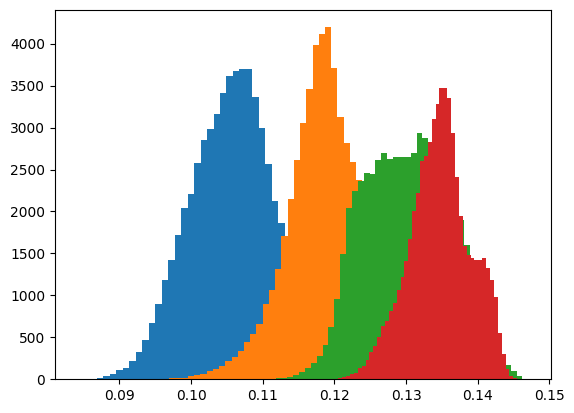

In [87]:
layer_cushion_lists=[]
layer_cushion=[]
for n in range(number_of_layers):
    layer_cushion_lists.append([np.linalg.norm(np.dot(trained_network_weights[n],input_vectors_after_activation[n][k])/(np.linalg.norm(trained_network_weights[n])*np.linalg.norm(input_vectors_after_activation[n][k]))) for k in range(len(flat_dataset))])
    layer_cushion.append(min(layer_cushion_lists[-1]))

plt.hist(layer_cushion_lists[1],bins=50)
plt.hist(layer_cushion_lists[2],bins=50)
plt.hist(layer_cushion_lists[3],bins=50)
plt.hist(layer_cushion_lists[4],bins=50)
plt.show()

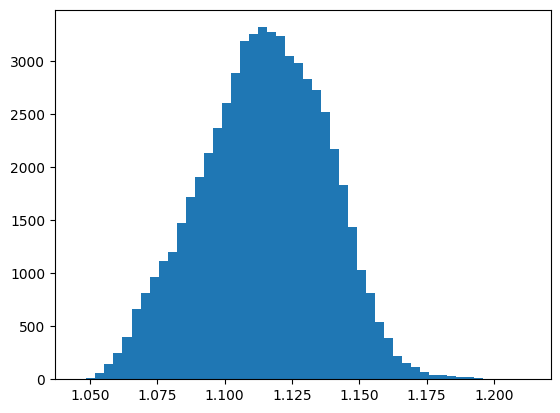

In [88]:
layer_activation_lists=[]
layer_activation=[]
for n in range(number_of_layers):
    layer_activation_lists.append([np.linalg.norm(input_vectors_before_activation[n][k])/np.linalg.norm(input_vectors_after_activation[n][k]) for k in range(len(flat_dataset))])
    layer_activation.append(min(layer_activation_lists[-1]))
c=max(layer_activation)

plt.hist(layer_activation_lists[3],bins=50)
plt.show()